# Machine Learning Engineer Nanodegree

## Capstone Project

#### Luca Veronese
#### April 20th, 2017

## I. Definition

### Project Overview

I am one of the founders of a IoT startup company in Italy. This project aims to solve of a real world problem I’ve found working on a project we have been undertaking at a customer site. 

We have developed a people/object localization and tracking system to be used inside buildings that uses Bluetooth Low Energy (BLE, https://www.bluetooth.com/what-is-bluetooth-technology/how-it-works/low-energy) devices, commonly known as beacons, as the signal emitting source. These beacons are generally worn by people, for example they may be embedded on keyrings. The receiving side of the system are Raspberry Pi 3 devices (https://www.raspberrypi.org/products/raspberry-pi-3-model-b/), connected to a network inside the rooms, one per room. In the following text I will use the Raspberry abbreviation to avoid repeating the full device make and model. Raspberries sense the beacons in a given area, classify the signal and report the data to a Cloud server. Users can then display the location of people/objects in the building on a map in real time using a client application:

![Sample image of localization system](localization.png "The Localization system user interface")

The purpose of the system is to detect when people enter a room or exit the room. It is not required to identify the exact position of people inside the rooms. The system also supplies access policies management with alerting, for example to detect violations when someone enters a room he/she is not allowed to enter.
As I will describe in full detail in the problem statement this is a classification problem. I have analyzed various approaches to similar problems regarding localization. Many of these approaches are suitable for the case where multiple observations coming from multiple sensors are used to learn a single spatiotemporal function (D. Gu and H. Hu, “Spatial Gaussian process regression with mobile sensor networks,” IEEE Transactions on Neural Networks and Learning Systems, vol. 23, no. 8, pp. 1279–1290, 2012.) or where multiple input features are provided (A. Shareef, Y. Zhu, and M. Musavi, “Localization using neural networks in wireless sensor networks,” in Proceedings of the 1st International Conference on Mobile Wireless Middleware, Operating Systems, and Applications, 2008, pp. 1–7.). As we will see, my problem is more constrained and simple, so I decided to make a personal proposal for a solution.

### Problem Statement

BLE devices are known for their inherent imprecision. The signal strength (RSSI, https://blog.bluetooth.com/proximity-and-rssi) is extremely unstable over time and in changing environments. Our application needs to state if a person is present inside a room in a building with high precision and low latency. Oftentimes a beacon is perceived by multiple antennas on nearby rooms or the signal is intermittent or absent for a significant period of time, or the signal values are characterized by high variance (Here by variance we intend the statistical notion of variance: the average of squared differences from the mean). In addition the signal behavior varies from room to room and depends on the size and geometry of the room, the furniture inside it and the location of the Raspberry device.

Our problem is to identify when a beacon enters a given room and when it exits the room using the signals received from the antenna located in the room. The beacon emits a signal nearly every second (this is a customizable parameter), so the sequence of signals received is a time series. We need to detect the enter/exit events indexes in the sequence of observations. Many beacons will concurrently move inside a building and each room will have one antenna. We consider all beacons equal but we need to learn a different model for each room since each room has different features (size, furniture, materials, ...). If two beacons are in the same room at the same time they represent independent time series, each one referring to a different beacon. Our problem is a classification problem where each observation in the time series can be labeled in two ways: IN or OUT, where IN means the beacon is inside the room, and OUT means it is outside of it. A single time series is defined by a single beacon on a single room from the time the beacon is first detected by the antenna to the time the beacon is no longer detectable by it.
This system is currently implemented using a naïve solution that computes simple moving averages of the RSSI computed over the series to clean the values a bit and stabilize them but this solution is inadequate. Currently we label all detected signals as meaning IN and only detect an OUT event when the beacon is no longer detected (using a timeout of several seconds). This is a problem since a beacon can be detected when it is significantly far from the room, or is in nearby rooms, and signals are sometimes interrupted for unpredictable time intervals even when the beacon is stationary inside the room. This causes many spurious events to be emitted. 

For our purposes what matters the most is to be able to detect real events. We should avoid detecting fake events caused by fluctuations in the RSSI since alerts may be connected to the event, and we want to avoid generating false alerts. It is acceptable to detect the event with a given temporal delay, albeit we should try to minimize the delay as much as possible. As we will see there is a trade off between minimizing the probability of fake event detection and minimizing the event detection delay.

### Datasets and Inputs

The features I will be using are the RSSI values measured from the Raspberries as well as the delay in milliseconds between successive measures. I have implemented a function to collect labelled samples on the field (the code is written in JavaScript (http://www.ecma-international.org/publications/standards/Ecma-262.htm) running on node.js (www.nodejs.org) inside the Raspberry Pi). A field technician can start the sample collection and move inside and outside a given room, signaling his/her position (using a portable computer), so we can add the target feature (IN/OUT binary variable) to the other two. Our input files will then have three features: RSSI value, delay from last measure, beacon inside/outside. The last feature is the feature to be predicted and the class labels are IN and OUT as described in the previous section. This data can easily be obtained from our current instrumentation and there is no privacy problem related to it. This is the data I can obtain on the field. I could think of additional features to add in order to generalize the model and use much more data. For example some additional features could be: room sizes, presence of furniture, position of the Raspberry inside the room, and so on. In this way I may create a single model for all the rooms. I have resisted this temptation since the purpose of this system is to create an easy to use setup procedure for installers that set these devices up, so I can’t force them to provide additional information like exact positions of objects on a coordinate system. In this problem, the limitation in terms of number of available features has a fundamental role in shaping the solution I came up with.

### Solution Statement

For this project it seems I have no out of the box ML algorithm that can be reasonably applied to the problem. I will have to invent a solution and I want to start with a simple one that can be implemented in a short amount of time and that I can understand well. My thought is: "if this works then we are done, otherwise this will be our new benchmark model".
As we will see shortly, the data is not easy to separate into classes. This rules out logistic regression and SVMs. Having only two features (indeed one as we will see shortly), classification trees seem not that useful. Besides, all these algorithms can't take advantage of the time series property of this data. Neural Networks may work but using them with this sort of data is clearly more complex than the hypothesis I'm going to suggest next and given the small amount of data available for this problem it seems to me it is difficult to learn a Neural Net that can generalize well without overfitting too much.

If we had a coordinate system with precise locations for the Raspberries and room sizes and multiple sensors we may use known algorithms for localization like Kalman filters and particle filters (https://www.udacity.com/course/artificial-intelligence-for-robotics--cs373). This may be a solution for other kind of situations but for this specific use case we are trying to detect an IN/OUT event, we have no coordinates and a single antenna per room. Classical localization algorithms seem not to be a good fit since they assume multiple sensors and are optimized to predict a location for a moving target (so they need a coordinate system).

It is to be expected that the average RSSI value inside the room should be significantly higher than the average value of the RSSI measured outside the room. The problem is that the high signal variance we measure from the beacons makes it difficult to use this knowledge to detect the event when it happens and there is high probability to detect spurious events.

The solution I suggest is to use a probabilistic model based on Gaussian distributions. The data I get, being repeated observations of the RSSI over time, should be reasonably distributed as a Gaussian (at least the distribution is symmetric and unimodal if the antenna is placed centrally in the room). If I partition my observations into two sets based on the labels, I can estimate the parameters of two gaussian distributions that represent the probability of observing a given RSSI value assuming the two hypotheses of being inside or outside the room. I can use some comparison between these probabilities to classify the observations and detect the interesting events. The algorithm I’m going to describe in the Analysis section is a refinement of this basic idea.

I underline the fact that I didn't get this specific idea from any existing work but I was inspired to pursue it from my studies in Statistics (I have a degree in Statistics) and from material from the AI for Robotics course I have undertaken after completing all the projects up to this capstone. Anyway, combining gaussian distributions to create more complex models is a well known practice in the field (see for example Gaussian Processes, Gaussian Mixture Models, and so on). My solution is much simpler than those models but it is the right "size" solution for the problem at hand.

I'm also going to collect the delay between subsequent observations. It is a piece of data that I can obtain for free during the collection phase (we call it the antenna training phase). I don’t know if this feature will be useful and will allow us to improve our solution but the rationale for using it is that I expect delays inside the room to be much smaller than delays outside it. If this is true this feature can further help us in the classification task. We also need to see how much RSSI is correlated with the delay in order to verify if the delay feature is redundant. For it to be useful, the delay should be highly "correlated" with the labels and should have low correlation with the RSSI. I will verify the usefulness of the delay during the data exploration phase. Should it be useful we will need to use bivariate gaussian distributions.

### Metrics

In order to evaluate the quality of a solution we need to define a metric that will be used to compare different solutions. Since this is a classification problem, we are interested in measuring how many observations are correctly classified by our algorithm. In the field there are various metrics that can be used to evaluate the score of a solution for classification problems. The most used are: F1 score; Accuracy; Precision and Recall. In our problem the classes IN and OUT are not skewed, the fact of being inside or outside the room is equally represented in our training samples and the cost of a false positive is equal to the cost of a false negative. So I would actually not use Precision and Recall and consequently the F1 score. I think Accuracy is the best metric in our case, measuring the ratio between the count of correct predictions and the total number of observations in the training sample.

## II. Analysis

### Data Exploration

The data I will use for this project has been collected by myself using functionality I implemented inside the application. The purpose of the data collection function is to collect a balanced sample of observations where the sample contains roughly the same amount of observations labelled IN and OUT. In order to explain how I collected the data I need to describe the architecture of the system. The system is composed of three pieces of software:
- The software running inside the Raspberry PI 3, which is written in JavaScript and runs on the node.js platform. The responsibility of this subsystem is to acquire data from the surrounding beacons, preprocess it, and transmit the results to the server component;
- The server, running on the Cloud (www.heroku.com at the moment), is a node.js application that coordinates the collection of data from the Raspberries, stores the data in a PostgreSQL (www.postgresql.org) database, and provides the data to the clients for consumption. The server and the Raspberries communicate through the websockets (https://en.wikipedia.org/wiki/WebSocket) protocol;
- The client is a JavaScript application that talks to the node.js server through the websockets protocol. It sends commands to the server and receives the data about people location and displays the data on a map in real time. It can also show historical data.

In order to collect the data, the user selects a Zone (room), tells the client which beacon will be used for training data collection and starts the collection phase by pushing the "Taratura" button in the UI (sorry, the UI is in the italian language):

![Image of dialog for starting data collection](antenna_setup.png "Dialog for starting data collection")

The client asks the server to start collecting data, the server sends a command to the Raspberry on the selected zone, which starts collecting the data. As data is being collected the user moves inside and outside the room. Each time the user exits or enters the room he/she signals the event by pressing a button in the UI. This triggers a message to the Raspberry who switches the label value for the data being collected. In the end we get data in this JSON format (sample):

`{ "sample": 
   [ { "rssi": -80, "pos": 0, "ts": 1490443597934 },
     { "rssi": -86, "pos": 0, "delay": 1001, "ts": 1490443598935 },
     { "rssi": -82, "pos": 0, "delay": 1010, "ts": 1490443599945 },
     { "rssi": -82, "pos": 0, "delay": 1009, "ts": 1490443600954 },
     ...
     { "rssi": -93, "pos": 1, "delay": 2004, "ts": 1490443670259 },
     { "rssi": -92, "pos": 1, "delay": 13060, "ts": 1490443683319 },
     { "rssi": -91, "pos": 1, "delay": 1003, "ts": 1490443684322 },
     { "rssi": -85, "pos": 1, "delay": 2005, "ts": 1490443686327 },
     { "rssi": -88, "pos": 1, "delay": 1010, "ts": 1490443687337 },
...
     { "rssi": -79, "pos": 0, "delay": 1008, "ts": 1490443795867 },
     { "rssi": -77, "pos": 0, "delay": 1007, "ts": 1490443796874 },
     { "rssi": -78, "pos": 0, "delay": 1003, "ts": 1490443797877 },
     { "rssi": -81, "pos": 0, "delay": 2012, "ts": 1490443799889 },
...
     { "rssi": -89, "pos": 1, "delay": 4021, "ts": 1490443863233 },
     { "rssi": -83, "pos": 1, "delay": 10047, "ts": 1490443873280 },
     { "rssi": -86, "pos": 1, "delay": 1004, "ts": 1490443874284 },
...
 ]}`
 
We are interested in the three features: *rssi*, *pos* and *delay*. The *ts* feature is the collection timestamp and is not interesting for our purposes. The features of interest are:
- RSSI: (Received Signal Strength Indication). The rssi value provided by the beacon and read by the Raspberry. It is a negative value. Bigger values (nearer to zero) mean stronger signal, while lower values (far from zero) mean weaker signal. RSSI is a signal strength percentage and varies from manufacturer to manufacturer. So it is not an absolute value. For our purposes, since in a given installation we use identical beacons, the absolute values are not relevant and as we will see our algorithm is actually sensible to trends over time of the RSSI. The RSSI value we get in the sample is an integer value but we will be treating the RSSI as a continuous variable. In reality the RSSI value may contain fractional digits;
- pos is our target label to be predicted. It assumes two values: 0 for IN (inside the room) and 1 for OUT (outside the room). Our objective is to predict pos from RSSI and delay. So this characterizes our problem as a classification problem, since the target variable to predict is categorical;
- delay: is the delay in milliseconds for the signal arrival to the Raspberry since the previous signal was received. The beacon is setup to transmit every second (1000ms) but as we can see from the data, the delay is a random variable. Whether the delay feature can be useful for predicting pos is a fact to be determined in this analysis phase.

In order to more easily process this data in python I converted it to CSV format using a small JavaScript script. The final structure of the data is (sample):

`"rssi","pos","delay"
-80,0,
-86,0,1001
-82,0,1010
-82,0,1009
-84,0,1007
-82,0,1008
-79,0,2011
…`

For the first observation the delay feature is obviously missing. Apart from this all the observations have all the data.
In order to remove the missing value I will ignore the first observation. 
Given the data collection approach and the nature of the system I tend to exclude the presence of outliers in the samples I collected. Also, given the algorithm I’m going to describe next, there is no need for transformations on the raw data collected.
For this project I collected two samples gathered independently using the software in the same test room. 
The two samples contain 200 observations each and the observations should be nearly evenly distributed between the two pos labels (0 and 1). 
In order to understand the data I computed these statistics for the two samples

In [9]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from IPython.display import display # Allows the use of display() for DataFrames

# Pretty display for notebooks
%matplotlib inline

# Load the dataset
in_file = 'data/newdata1.csv'
sample1 = pd.read_csv(in_file)
# remove first row to get stats right
sample1.dropna(inplace=True)

# Print descriptive statistics
display(sample1[sample1['pos'] == 0].describe())
print("Sample 1: IN labelled")
display(sample1[sample1['pos'] == 1].describe())
print('Sample 1: OUT labelled')

in_file2 = 'data/newdata2.csv'
sample2 = pd.read_csv(in_file2)
# remove first row to get stats right
sample2.dropna(inplace=True)

# Print descriptive statistics
display(sample2[sample2['pos'] == 0].describe())
print('Sample 2: IN labelled')
display(sample2[sample2['pos'] == 1].describe())
print('Sample 2: OUT labelled')

,rssi,pos,delay
count,100.0000,100.0,100.000000
mean,-71.7500,0.0,1126.000000
std,5.8212,0.0,328.195126
min,-86.0000,0.0,995.000000
25%,-76.0000,0.0,1003.750000
50%,-71.0000,0.0,1007.000000
75%,-68.0000,0.0,1009.000000
max,-60.0000,0.0,2016.000000


Sample 1: IN labelled


,rssi,pos,delay
count,100.000000,100.0,100.000000
mean,-80.880000,1.0,1155.340000
std,6.057436,0.0,387.889061
min,-96.000000,1.0,998.000000
25%,-85.000000,1.0,1003.000000
50%,-80.000000,1.0,1005.000000
75%,-77.000000,1.0,1008.000000
max,-69.000000,1.0,3010.000000


Sample 1: OUT labelled


,rssi,pos,delay
count,102.000000,102.0,102.000000
mean,-73.705882,0.0,1132.686275
std,6.883167,0.0,440.080798
min,-93.000000,0.0,998.000000
25%,-78.000000,0.0,1003.000000
50%,-72.000000,0.0,1005.000000
75%,-69.000000,0.0,1007.000000
max,-62.000000,0.0,4027.000000


Sample 2: IN labelled


,rssi,pos,delay
count,98.000000,98.0,98.000000
mean,-81.265306,1.0,1301.887755
std,6.296049,0.0,580.063681
min,-99.000000,1.0,998.000000
25%,-84.000000,1.0,1003.000000
50%,-81.000000,1.0,1006.500000
75%,-77.000000,1.0,1011.750000
max,-70.000000,1.0,4010.000000


Sample 2: OUT labelled


Some observations about the statistics above (for all samples):
- the average RSSI for IN observations is significantly lower than the average RSSI for OUT observations;
- the standard deviations of RSSI for IN and OUT observations are not significantly different;
- considering the means and standard deviations observed, there is a significant overlap of high probability values for RSSI and delay on both distributions (assuming gaussian distributions);
- the delay averages and standard deviations between IN and OUT labelled observations are not significantly different. We can conclude that delay is not really distributed differently for IN and OUT observations. This means the delay feature is not relevant for our purposes;
- the two independently gathered samples show no significant difference in the statistics. We can conclude that our samples are representative of the population of all samples we can gather in the same conditions (beacon/room/data acquisition methodology).


### Exploratory Visualization

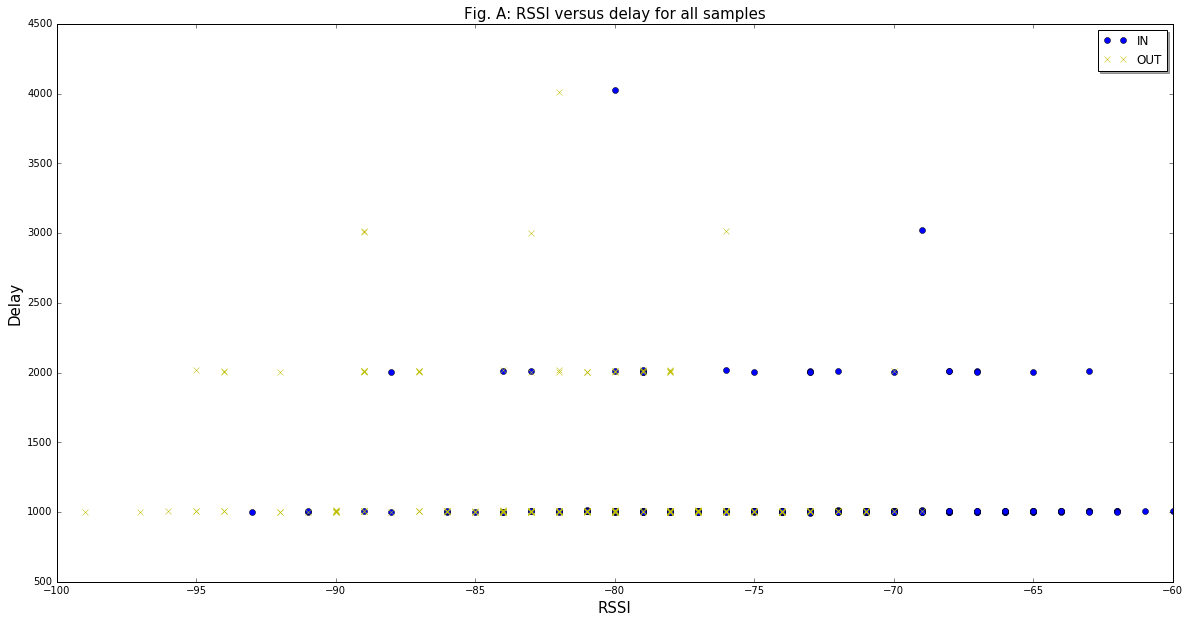

In [10]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Combine the three samples for visualization
all_data = pd.concat([sample1, sample2])
in_data = all_data[all_data['pos'] == 0]
out_data = all_data[all_data['pos'] == 1]

fig, ax = plt.subplots(figsize=(20, 10))
ax.set_xlabel("RSSI", fontsize=15)
ax.set_ylabel("Delay", fontsize=15)
ax.set_title("Fig. A: RSSI versus delay for all samples", fontsize=15)

ax.plot(in_data['rssi'], in_data['delay'], 'o', label="IN")
ax.plot(out_data['rssi'], out_data['delay'], 'x', color='y', label="OUT")
plt.legend(shadow=True)

From the visualization in Figure A we can confirm that high RSSI values correspond to the IN label and low RSSI values correspond to the OUT label as expected. We can also confirm that there is a range of RSSI where there is significant overlap between the labels (from circa -94 to circa -71). The diagram confirms the suspect that the delay is not so relevant to predict in and out labels. The fact that delays are scattered into discrete values of 1 second tells us that the delay is actually to be interpreted as a missed observation. The signal did not make to the antenna and the observation was lost. The data we have clearly shows that tha classification of an observation is totally independent from the delay. Indeed the delay feature will turn to be useful later on in order to make the algorithm more useful in the real world, but we will talk about this at the right moment.

If we plot the samples as time series in order to see how the RSSI values change over time:

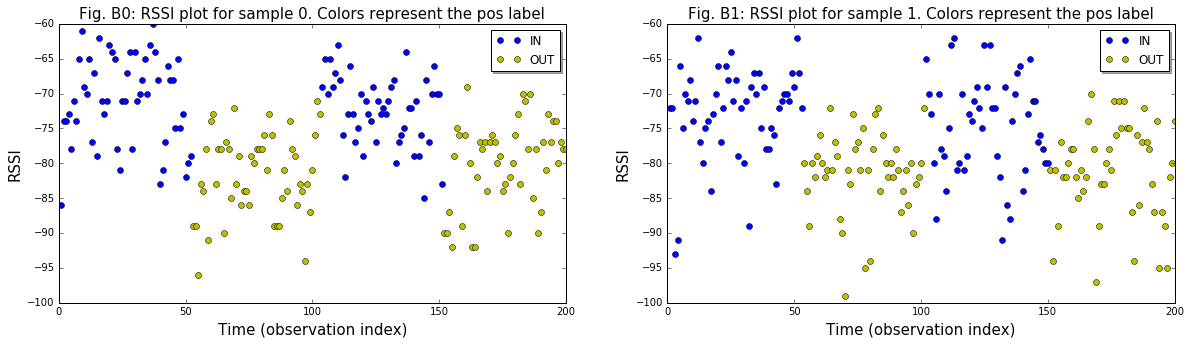

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

#
# Splits a series into lists of contiguous values for the target label (POS)
# sample - the sample to split
#
def split(sample):
    ret = []
    curval = -1
    curvec = []
    for e in sample.iterrows():
        if (curval == -1):
            curval = e[1]['pos']
        if (e[1]['pos'] == curval):
            curvec.append({
                'pos': e[1]['pos'], 
                'rssi': e[1]['rssi']
            })
        else:
            ret.append(curvec)
            curvec = [{
                'pos': e[1]['pos'], 
                'rssi': e[1]['rssi']
            }]
            curval = 1 - curval
    if (len(curvec) > 0):
        ret.append(curvec)
    return ret

#
# plots the lists in a single plot with different line colors for the two labels IN and OUT
# sample - the sample to plot
# ax - the plot to draw into
# sampleId - the sample identifier
# addTitle - Boolean, whether to add title or not
#
def plotSegmentedSeries(sample, ax, sampleId, addTitle=True):
    shift = 1
    if addTitle:
        ax.set_title('Fig. B' + sampleId + ': RSSI plot for sample ' + sampleId + '. Colors represent the pos label', fontsize=15)
    ax.set_ylabel('RSSI', fontsize=15)
    ax.set_xlabel('Time (observation index)', fontsize=15)
    splits = split(sample)
    for s, idx in zip(splits, range(len(splits))):
        color = 'b' if s[0]['pos'] == 0.0 else 'y'
        if idx < 2:
            lb = 'IN' if color=='b' else 'OUT'
        else:
            lb = '' # in order to get only one set of legends
        ser = pd.Series([i['rssi'] for i in s], index=range(shift, shift+len(s)))
        ax.plot(ser, 'o', c=color, label=lb)
        shift = shift + len(ser)
        if (color == 'y'):
            color = 'b'
        else:
            color = 'y'            
    ax.legend(shadow=True)

# draw plots for the two samples
plotSegmentedSeries(sample1, ax[0], "0")
plotSegmentedSeries(sample2, ax[1], "1")

we can see that, in general, observations belonging to the IN label (the yellow ones) tend to distribute around a higher RSSI value while those for the OUT label (the blue ones) tend to lower average RSSI. This is the basic observation that inspires the algorithm I'm going to explain next. Another observation is that the observed values fluctuate a lot (the variance of observations is high). This is a problem the algorithm will need to cope with in order to correctly classify the observations with the correct label.

## Algorithms and Techniques

Each data sample is a time series where the observations are ordered and time dependent. We are actually interested in the point in time in which the beacon changes position (inside to outside and vice versa). My idea is to learn the parameters of two normal distributions from the set of IN labelled observations and the set of OUT labelled ones using a training time series and use the resulting models to compare the probabilities for a given observation in the two hypotheses. A simple metric we can use is the ratio between P<sub>IN</sub>(RSSI)/P<sub>OUT</sub>(RSSI) where P<sub>IN</sub> is the probability under the IN gaussian and P<sub>OUT</sub> is the probability under the OUT gaussian and RSSI is the observed RSSI. A value much greater than 1 would strongly indicate the beacon is inside the room while a value near 0 would strongly indicate the beacon is outside the room. If the gaussians centers are significantly distant and the variances are comparable then this metric is going to be effective. The problem is we observed the variances to be high. This means that we will see significant fluctuation in the metric over time and this metric will often predict spurious events which we want to avoid as much as possible. In order to improve our solution we can observe that we have a time series. This means that subsequent observations are somewhat related. If I am inside the room subsequent observations will all come from the same IN distribution, and the opposite can be said if I am outside. So one thing we can do is to use multiple subsequent observations (a window) to compute a joint probability for the two assumptions (represented by the IN and OUT gaussians), computing a comparison metric over a sliding window of time. The window size N will be an hyperparameter of our model. In this way fluctuations will be absorbed by the joint probability distribution and the metric will be stable over time. This will minimize the probability of predicting spurious events.

Ultimately, the metric I suggest to implement for the solution model is:

$$M = \frac{P_{IN}(RSSI_{1}, RSSI_{2}, ..., RSSI_{N})}{P_{OUT}(RSSI_{1}, RSSI_{2}, ..., RSSI_{N})}$$

where P(..,...,...) is the joint probability of the observations (in the window), $P_{IN}$ denotes the probability calculated on the IN gaussian, likewise $P_{OUT}$ denotes the probability calculated for the OUT gaussian. 

While the beacon is "IN", M should be much greater than 1. If the beacon is "OUT", M should be much smaller than 1. So M = 1 should be our reference threshold to use to detect the event.

From our training data we know the exact index in the observations sequence at which the IN/OUT event happens. An optimal model must be able to predict the change at that index. Any deviation between predicted and observed target label value has to be penalized, as well as any spurious event prediction (predicted by the model but not happened in the observations).

In our domain it is acceptable to have a few seconds of delay in the detection of the event. The best model is the one that minimizes this delay without producing spurious events. This two requirements are unfortunately in conflict: the shorter the desired delay, the higher is the probability to detect a spurious event.

Spurious events should be penalized more than lags or leads in event detection since we don’t want the system to behave erratically but in order to keep the cost function simple at least for now I won't make this distinction. There will be extensive treatment of this problem later.

In order to evaluate our model we will use the accuracy metric, computing the ratio between correctly classified observations and the total number of observations.

The value of N in the solution model is a hyperparameter that must be learned in order to minimize a cost function for the solution model. I will evaluate the solution model for various values of N from 1 to 10 computing a cost function and will choose the value of N that minimizes the cost function. A maximum value of 10 is arbitrary but is reasonable. A higher N value means a higher delay in event detection and a value of 10 is the maximum reasonable value in our domain, given the signal rate is one observation per second.

The cost function will simply be the count of misclassified observations in the sample, where the classification of a given observation during hyperparameter tuning is carried out by using the following function:

$$predict = 0\verb! if !M \geq 1; 1\verb! if !M < 1$$

Where 0 maps to the IN label and 1 maps to the OUT label. When M = 1 the classification is arbitrary but in practice the probability of observing exactly 1 is so low that we can ignore this little problem.
Since we will use the same sample to compute the cost function for all potential values of N this value does not need normalization. This cost is not comparable between different samples but comparing the cost of different samples is not interesting to us. In practice we will have only one sample available.
When the observation index I (0-based) is less than N we will compute the joint probability of the first I observations. As soon as I >= N we will compute the joint probability for the observations from I-N+1 to I.

## Benchmark

As a benchmark model I will use the results of our current implemented solution which is not using any probabilistic model. This will be our baseline for comparing the new model and evaluating its performance. In our system we need a filter function that generates a stream of events from the stream of RSSI observations in a reactive fashion (see https://en.wikipedia.org/wiki/Reactive_programming). In practice, without a ML model there is no way to write that function. So our first approach was simply to label as IN any observation from a beacon that is currently being detected and to emit an OUT event only when a timeout occurs without any further observation being received by the antenna for that beacon. This is a very limited solution since we may detect people walking for example in a hallway and classify them as being inside the nearby room.

The accuracy of the current implementation is easy to compute since it classifies every observation with the IN label. This means in our samples, given the even distribution of observations by pos label, it will normally have an accuracy near 50%. This is the baseline to improve on and we aim at a very significant improvement over this value.

For the solution model we will compute the predictions (IN, OUT) from the sequence of observations using a sliding window of N observations and use them to compute the cost using the cost function I described in the previous section. This function can be applied to both the benchmark and the solution model, its application to the benchmark model being trivial as described in the previous paragraph.

## III. Methodology

### Data Preprocessing

From the previous sections it should be clear that:
- we will only use the RSSI feature to learn our model leaving out the delay feature which from the exploratory analysis turns out not to be useful;
- in order to compute the parameters of our gaussian distributions we do not need to perform any feature transformation;

*Note for the reviewer: I preprocessed the JSON files emitted by the system with a simple JavaScript script in order to obtain the CSV files I will use in the python code as required for this report. If this constitutes a violation of the "all code should be python" rule I can easily rewrite the script in python.*

### Implementation

It should be clear that the real implementation of the algorithm is written in JavaScript and runs inside a node.js instance in the production system. This choice was made to have the same language and platform on the Raspberry, on the cloud server and on the client application running inside the browser. This lowers the requirements on other programmers in order to maintain the code I have written. In order to comply with the requirement that all the code in the capstone project must be written in python I will provide an equivalent python implementation for the parts of interest for the purpose of the capstone project.
I didn't find any particular difficulties in writing the code. The code is not complex and I am a professional programmer (I have been programming for more than 30 years in a great variety of languages and platforms). The only difficulty I had was familiarity with the plotting libraries, but nowadays learning how to use a library is quite simple, thanks to Google...

The steps required to implement the basic algorithm I described previously are:
- use the data to learn the parameters of the two gaussian distributions IN and OUT. This is simple since those parameters are the mean and standard deviation of the RSSI feature in the (filtered by label) samples which we already computed in the Exploratory analysis phase;
- learn the best value for the N hyperparameter in order to determine the final model that will be used to classify unseen series of observations. This requires writing some code and deciding how we are going to compute the joint probabilities for a window of N observations.
Now, about the join probability calculation problem, I'm going to make the simple assumption that subsequent observations in the series are independent. This is probably true if the beacon is steady since the variation in the observed RSSI depends only on random fluctuations caused by many factors (beacon hardware, radio interference, obstacles between the beacon and the antenna, and so on) and these can be considered independent and identically distributed as gaussians. If the beacon is moving from inside to outside and vice versa, subsequent observations are somewhat correlated by the fact that the RSSI is decreasing or increasing on average as we move near or further from the antenna. But the purpose of our algorithm is to detect a change in the RSSI distribution that signals the change in beacon position. Our metric should be robust enough even when the observations are somewhat correlated due to movement because it simply compares the two hypotheses: "I am steady inside the room" and "I am steady outside it". What matters to us is the relative weight of the two hypotheses which is going to change rapidly as we change position. So, I think the simple solution of multiplying the probability densities for the observations in the window is what is sufficient for our purposes.
- in order to learn the value of the N hyperparameter we should in principle use a different sample to avoid overfitting. I could easily use one sample to learn the gaussian parameters and another sample to learn N but in practice the system will be capturing only one sample. Since the data is a time series, it is actually not easy to perform cross validation using only one sample since the order of observations matters. One possibility may be to break the time series into chunks of subsequent groups of IN an OUT observations and use two chunks to estimate the gaussian parameters and the other two to learn N (this is possible since the data set is collected by performing an IN-OUT-IN-OUT sequence of near 50 observations per chunk). This possibility will be explored in the Refinement phase. For the time being I will show the results of "cheating" using the same data set for both tasks. I will also show a test validation where I validate the models using the other sample as test data.

This brings us to this python code:

('Best N is ', 8, ' with cost ', 10.0, ' Accuracy: ', 95.0)
('Best N is ', 7, ' with cost ', 20.0, ' Accuracy: ', 90.0)


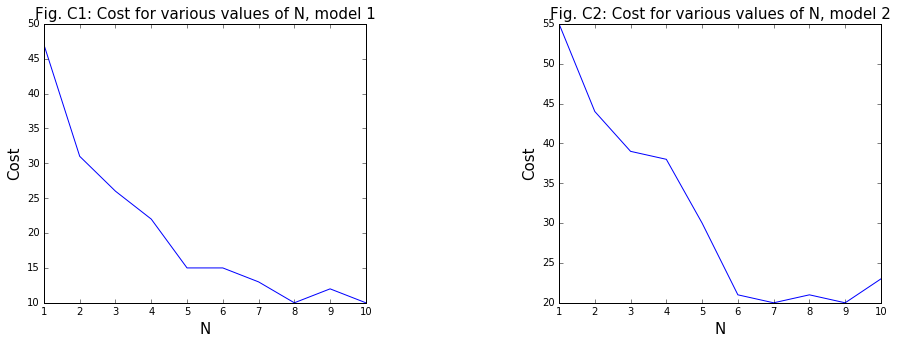

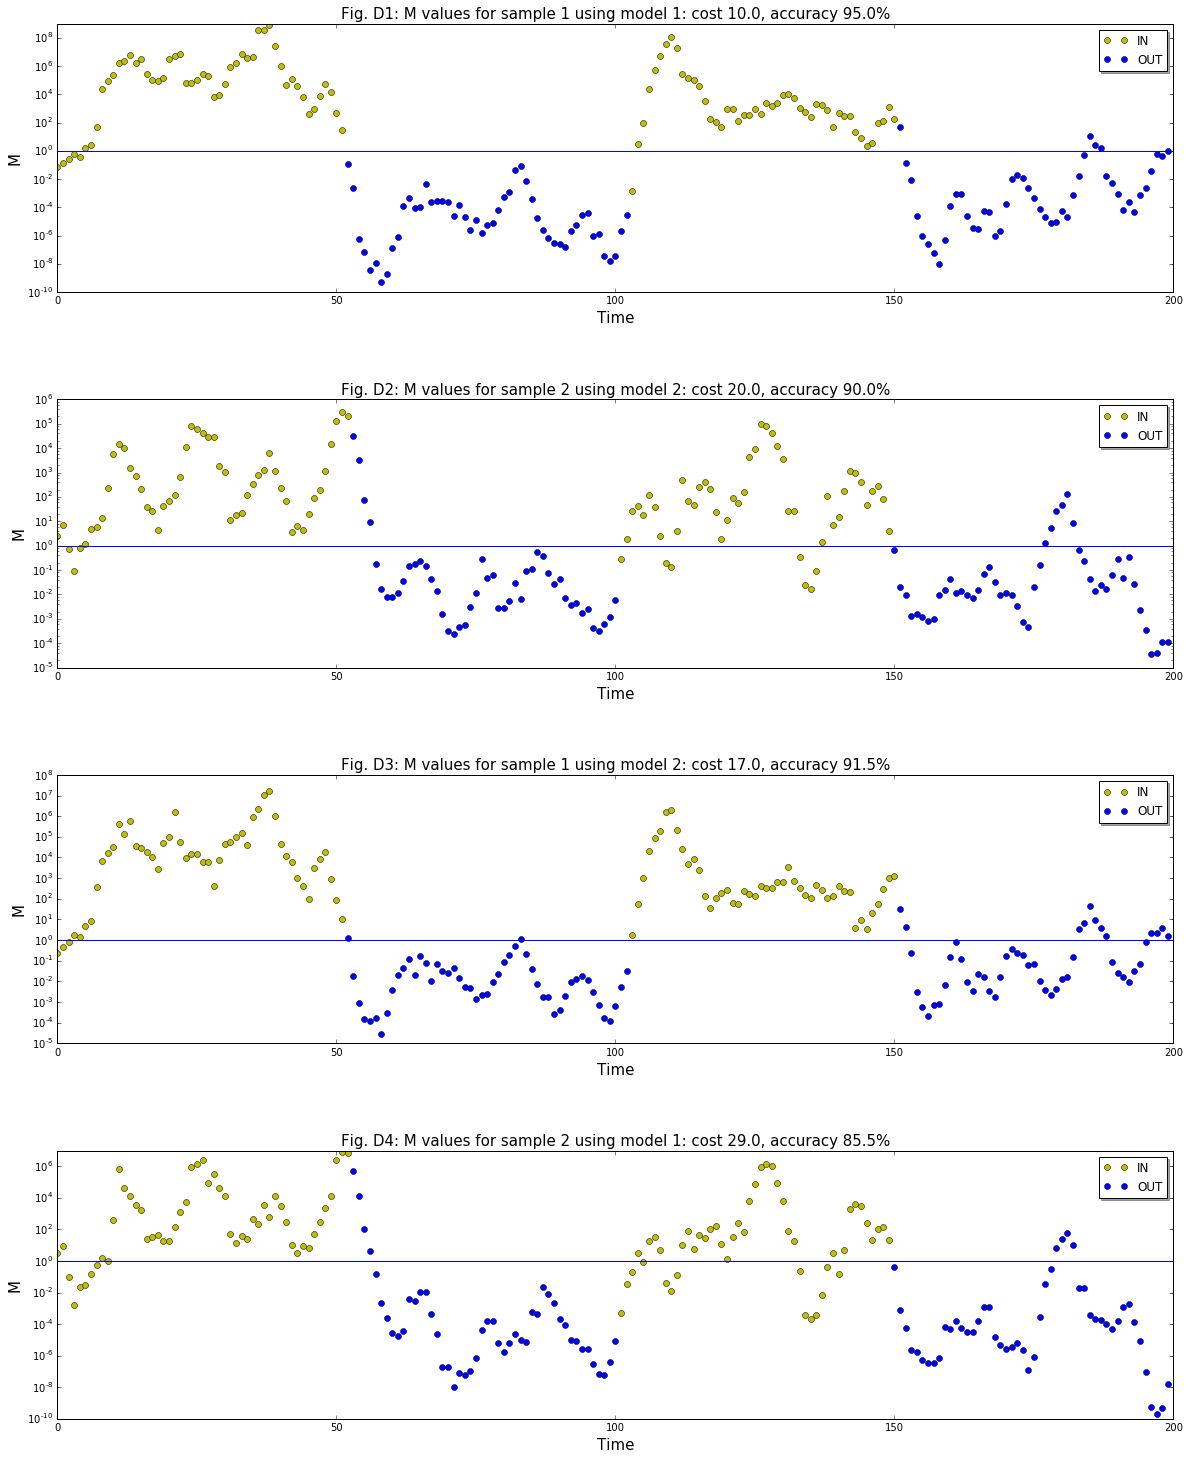

In [12]:
from scipy.stats import norm

# computes cost, values and labels for a given sample using given model
def evaluate_series(sample, model):
    obs_in = []
    obs_out = []
    cost = 0.0
    values = []
    labels = []
    for s in sample.iterrows():
        # obtain gaussian density from the two gaussians in the IN and OUT hypotheses
        val_in = norm.pdf(s[1]['rssi'], model['mean_in'], model['stddev_in'])
        val_out = norm.pdf(s[1]['rssi'], model['mean_out'], model['stddev_out'])
        # obs_in and obs_out contain our N-sized 'window' of densities
        obs_in.append(val_in)
        obs_out.append(val_out)
        # clip the size of the window to the last N values
        if (len(obs_in) > model['N']):
            obs_in.pop(0)
            obs_out.pop(0)
        # compute joint probabilities (by multiplication)
        joint_in = 1
        joint_out = 1
        for i in range(len(obs_in)):
            joint_in = joint_in * obs_in[i]
            joint_out = joint_out * obs_out[i]
        # Now we can compute the M value and prediction
        pred = 1.0
        M = joint_in / joint_out
        if M >= 1:
            pred = 0.0;
        # if prediction is not equal to observed value increase the cost
        if pred != s[1]['pos']:
            cost = cost + 1
        # save M values. They will be needed for plotting
        values.append(M)
        # save labels. They will be needed for plotting
        if (s[1]['pos'] == 0.0):
            labels.append(0)
        else:
            labels.append(1)
    return (cost, values, labels)

# builds model using sample as training data and sample2 for hyperparameter calculation
# stores title on model for subsequent reference
def build_model(sample, sample2, title):
    # first divide the sample into IN and OUT partitions
    samp_in = sample[sample['pos'] == 0]['rssi']
    samp_out = sample[sample['pos'] == 1]['rssi']
    # determine gaussian parameters for the partitions and initialize our model
    model = {
        'mean_in': samp_in.mean(),
        'mean_out': samp_out.mean(),
        'stddev_in': samp_in.std(),
        'stddev_out': samp_out.std()
    }
    # these will be returned inside our model
    min_cost = 9999.0
    min_n = 0
    cost_model = []
    min_values = []
    min_labels = []
    # try all possible values of N to find the one that minimizes the cost
    for N in range(1, 11):
        model['N'] = N
        # evaluate test sample with the current model
        (cost, values, labels) = evaluate_series(sample2, model)
        # save cost for later plotting
        cost_model.append(cost)
        # save the new cost and parameters if cost is lower than cost so far
        # if cost is equal we keep the old N value since a lower N is preferable (causes less delay)
        if min_cost > cost:
            min_cost = cost
            min_n = N
            min_values = values
            min_labels = labels
    # Now compute accuracy for out best N value
    accuracy = 100.0 - (min_cost / len(sample2))*100.0    
    print('Best N is ', min_n, ' with cost ', min_cost,' Accuracy: ', accuracy)
    # fill in model data and return our complete model
    model['N'] = min_n
    model['cost_model'] = cost_model
    model['values'] = min_values
    model['labels'] = min_labels
    model['accuracy'] = accuracy
    model['title'] = title
    return model

#plots series using sample evaluated on model using the axis ax and sample label sample_label
def plot_series(sample, model, ax, sample_label, fig):
    ax.set_xlabel("Time", fontsize=15)
    ax.set_ylabel("M", fontsize=15)
    (cost, values, labels) = evaluate_series(sample, model)
    accuracy = 100.0 - (cost / len(sample))*100.0
    ax.set_title("Fig. " + fig + ": M values for " + sample_label + " using " + model['title'] + ": cost " + str(cost) + ", accuracy " + str(accuracy) + "%", fontsize=15)
    ser = pd.DataFrame({'values': values, 'labels': labels})
    ax.set_yscale('log')
    ax.plot(ser[ser['labels'] == 0.0]['values'], 'o', color='y', label='IN')
    ax.plot(ser[ser['labels'] == 1.0]['values'], 'o', color='b', label='OUT')
    ax.plot([1] * 201, '-')
    ax.legend(shadow=True)

# plots cost for various values of N from 1 to 10
def plot_cost(model, ax, figname):
    ax.set_xlabel("N", fontsize=15)
    ax.set_ylabel("Cost", fontsize=15)
    ax.set_title("Fig. " + figname + ": Cost for various values of N, " + model['title'], fontsize=15)
    ser = pd.DataFrame({'values': model['cost_model'], 'labels': range(1, 11)})
    ax.plot(ser['labels'], ser['values'], '-')   

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
plt.subplots_adjust(wspace=0.6)
model1 = build_model(sample1, sample1, "model 1")
plot_cost(model1, ax[0], "C1")

model2 = build_model(sample2, sample2, "model 2")
plot_cost(model2, ax[1], "C2")

fig, ax = plt.subplots(4, 1, figsize=(20, 25))
plt.subplots_adjust(hspace=0.4)
plot_series(sample1, model1, ax[0], "sample 1", "D1")
plot_series(sample2, model2, ax[1], "sample 2", "D2")
plot_series(sample1, model2, ax[2], "sample 1", "D3")
plot_series(sample2, model1, ax[3], "sample 2", "D4")

A few observations about the diagrams:
- In general the algorithm does a good job at separating the blue (IN) observations in the above 1 range and the green (OUT) observations in the under 1 range;
- A few errors always happen at the start of the series when the window is not yet complete. The software system copes with this by not signalling any event until the window is complete;
- Some other errors happen at the switch between IN/OUT states (near 50, 100 and 150 indexes). These errors are intrinsic of the fact that we calculate a joint probability based on a window, so the M value takes a few observations to settle to the new switched state. In practice this is not a big problem since we can tolerate a few seconds of delay between the actual happening of the event and the signalling of the event by the system;
- What is more annoying is the fact we see spurious events happening, where the M=1 threshold is surpassed without a change in the actual color (label) of the observations. The server may be able to remove the false events using some time based threshold but the system is updating a real time visualization of the beacon positions and these false events will appear on the screen. Here more work is actually needed;
- it is clear that building the model on one sample, using it for hyperparameter selection, and then testing with the same sample introduces a lot of overfitting. The first two diagrams can't be taken for real. When we test with an unseen sample, like in the last two diagrams, it is clear that accuracy drops, but not so much in my opinion. The model still holds quite well.

### Refinement

#### Handling Overfitting

As expected, training on a single sample and using it for hyperparameter tuning and to test the model causes overfitting and is bad machine learning practice. We can see that from the last two samples where the error rate is significantly higher since that data has never been seen by the model. Different samples present variations not only due to the randomness of the signal but also on the way the operator collected the sample and any disturbing factors that happened during sample collection. 

Testing can be performed by directly trying the system after the training phase. In practice this means collecting a separate sample for testing. To exemplify this procedure, in the Implementation section we used sample2 to test model1 and sample1 to test model2 as the two samples have been independently collected and we saw the accuracy dropped by nearly 5% as expected. The operator can use the system to collect a test sample and get an accuracy measure after training. This is really useful in practice. If the accuracy is too low the operator may retry training the system in order to get better accuracy. We will further talk about this problem in the Results section.

I said earlier that it is not easy to perform standard cross validation on this samples since they are time series and the order of the observations is relevant. But there is a trick we can use to solve this problem. The collection procedure requires the operator to collect the data in four different subsamples: 25% IN, 25% OUT, 25% IN, 25% OUT. In reality this 25% may not be exactly respected but this is not a problem. It is not difficult to break our sample into subsamples in order to perform cross validation. We can mix the subsamples, using two subsamples for training and the other two for cross validation. In the end we can choose the model that has the lowest overall cost. In practice we are a bit constrained anyway since we need to use two contiguous subsamples (IN-OUT sequence) in order not to introduce skew in the process. Detecting the event is the purpose of the system, so it is not wise to mix IN and OUT subsamples coming from noncontiguous sections of the complete sample. This given, we can only perform two combinations of subsamples for cross validation purposes on the data we have currently. We could use both samples to increase the combinations to 12 but I resisted the temptation since in practice we collect only one sample. The following python code implements this idea:

('Best N is ', 10, ' with cost ', 3.0, ' Accuracy: ', 96.90721649484536)
('Best N is ', 6, ' with cost ', 5.0, ' Accuracy: ', 95.14563106796116)
('Best N is ', 10, ' with cost ', 9.0, ' Accuracy: ', 90.9090909090909)
('Best N is ', 6, ' with cost ', 7.0, ' Accuracy: ', 93.06930693069307)


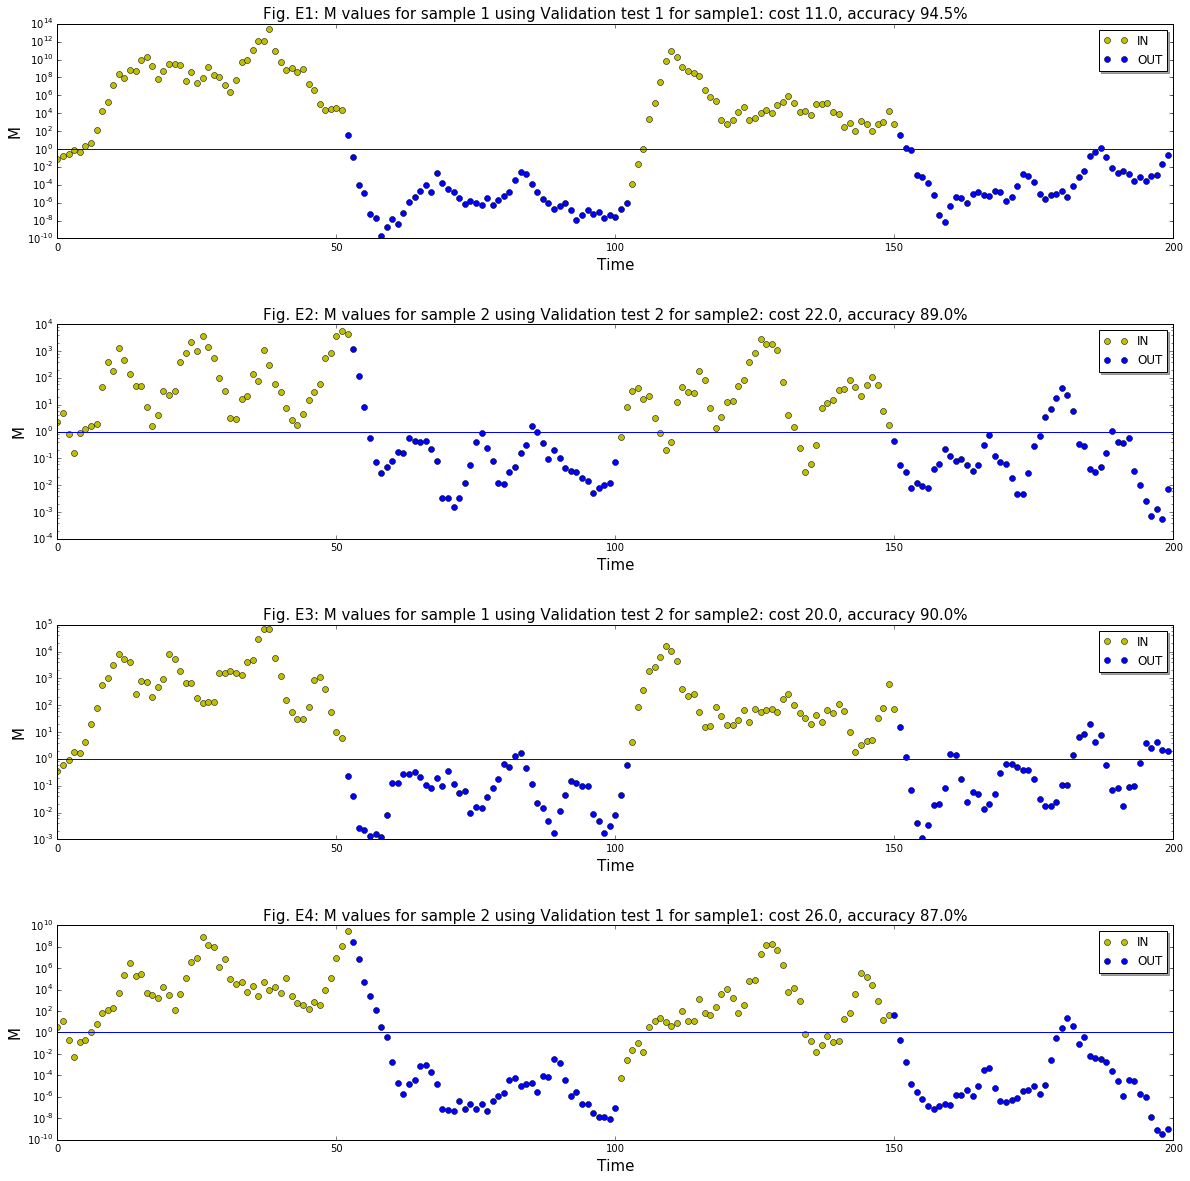

In [13]:
# we already defined the split sample function earlier. We will use it here
splitted1 = split(sample1)
splitted2 = split(sample2)

# build dataframes around subsample couples
df11 = pd.DataFrame(splitted1[0] + splitted1[1])
df12 = pd.DataFrame(splitted1[2] + splitted1[3])
df21 = pd.DataFrame(splitted2[0] + splitted2[1])
df22 = pd.DataFrame(splitted2[2] + splitted2[3])

model11 = build_model(df11, df12, 'Validation test 1 for sample1')
model12 = build_model(df12, df11, 'Validation test 2 for sample1')
model21 = build_model(df21, df22, 'Validation test 1 for sample2')
model22 = build_model(df22, df21, 'Validation test 2 for sample2')

chosen1 = model11 if model11['accuracy'] > model12['accuracy'] else model12
chosen2 = model21 if model21['accuracy'] > model22['accuracy'] else model22

fig, ax = plt.subplots(4, 1, figsize=(20, 20))
plt.subplots_adjust(hspace=0.4)
plot_series(sample1, chosen1, ax[0], "sample 1", "E1")
plot_series(sample2, chosen2, ax[1], "sample 2", "E2")
plot_series(sample1, chosen2, ax[2], "sample 1", "E3")
plot_series(sample2, chosen1, ax[3], "sample 2", "E4")


From this we can see that our cross validation approach improves sample2 results by 1.5% but worsens sample1 results by the same amount. This may due to the fact that sample2 is not as good as sample1 and splitting it for the purpose of performing cross validation increases the hyperparameter estimation error. The size of the data sample may be too small to be splitted in this way and this may affect the end result.

#### Improving the cost model

Another improvement I've been thinking about is to use a better cost model that explicitly reflects the fact that we want to penalize spurious events more than delayed event detection. The problem is: how do we identify misclassified observations that belong to a spurious event? We can observe that, due to delay, the first misclassified observation in a group has different pos label than the preceding one when we are going to see a real event, while the first misclassified observation in a group that identifies a spurious event is always preceded by an observation that has the same pos label value. This is not a mathematical truth but is highly probable. So we can detect these observations and increase their cost value. I decided to use a cost of 3 for these cases. I adjusted the code to implement this. I needed to separate the cost measure from the misclassified count in order to correctly compute the accuracy since the cost now is no longer the count of misclassified observations. I also increased the N range to 20 since this new cost model favors bigger values of N. The new code follows:

('Best N is ', 10, ' with cost ', 10.0, ' Accuracy: ', 95.0)
('Best N is ', 16, ' with cost ', 34.0, ' Accuracy: ', 86.0)


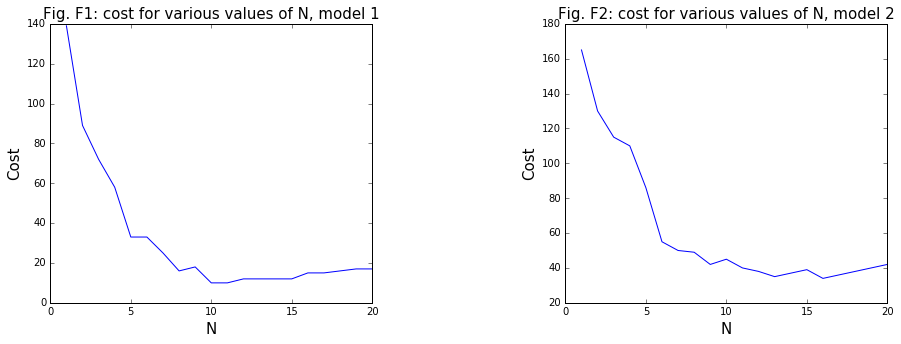

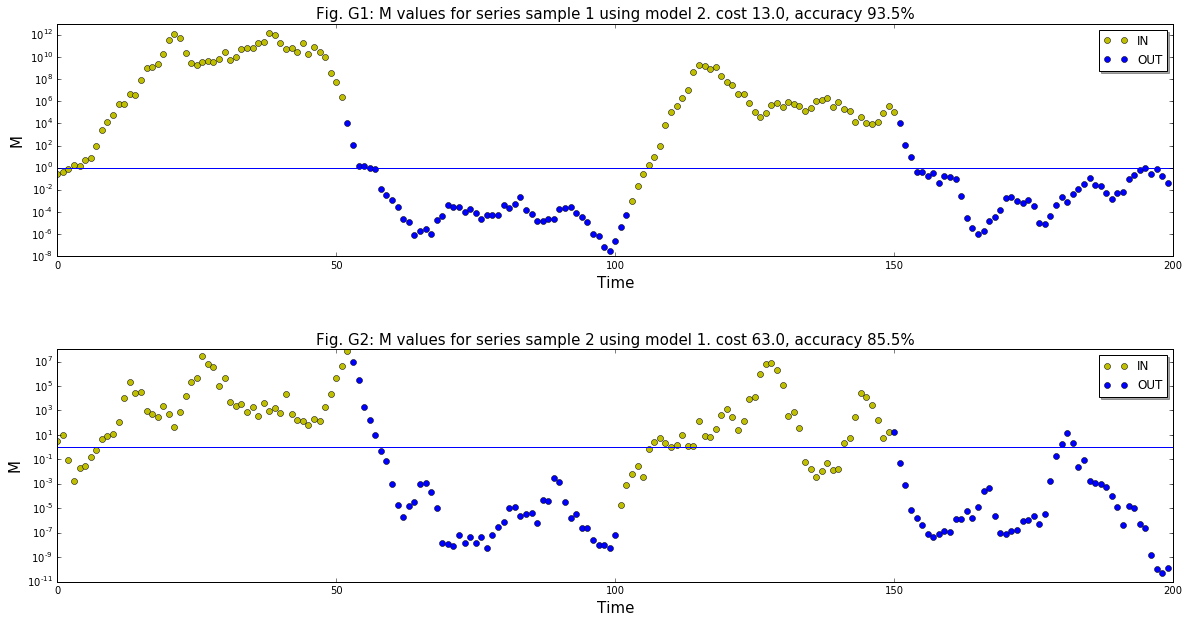

In [14]:
# computes cost, values and labels for a given sample using given model
def evaluate_series(sample, model):
    obs_in = []
    obs_out = []
    cost = 0.0
    misclassified = 0.0 # NEW: we need to count misclassifications now since cost has different metric
    values = []
    labels = []
    last_before_err = -1.0
    for s in sample.iterrows():
        # obtain gaussian density from the two gaussians in the IN and OUT hypotheses
        val_in = norm.pdf(s[1]['rssi'], model['mean_in'], model['stddev_in'])
        val_out = norm.pdf(s[1]['rssi'], model['mean_out'], model['stddev_out'])
        # obs_in and obs_out contain our N-sized 'window' of densities
        obs_in.append(val_in)
        obs_out.append(val_out)
        # clip the size of the window to the last N values
        if (len(obs_in) > model['N']):
            obs_in.pop(0)
            obs_out.pop(0)
        # compute joint probabilities (by multiplication)
        joint_in = 1
        joint_out = 1
        for i in range(len(obs_in)):
            joint_in = joint_in * obs_in[i]
            joint_out = joint_out * obs_out[i]
        # Now we can compute the M value and prediction
        pred = 1.0
        M = joint_in / joint_out
        if M >= 1:
            pred = 0.0;
        # if prediction is not equal to observed value increase the cost AND the NEW count of misclassified observations
        # since this will be necessary to compute the new accuracy
        if pred != s[1]['pos']:
            misclassified = misclassified + 1
            cost = cost + 1
            if last_before_err == s[1]['pos']:
                cost = cost + 2
        else:
            last_before_err = s[1]['pos']
        # save M values. They will be needed for plotting
        values.append(M)
        # save labels. They will be needed for plotting
        if (s[1]['pos'] == 0.0):
            labels.append(0)
        else:
            labels.append(1)
    return (cost, misclassified, values, labels)

# builds model using sample as training data and sample2 for hyperparameter calculation
# stores title on model for subsequent reference
def build_model(sample, sample2, title):
    # first divide the sample into IN and OUT partitions
    samp_in = sample[sample['pos'] == 0]['rssi']
    samp_out = sample[sample['pos'] == 1]['rssi']
    # determine gaussian parameters for the partitions and initialize our model
    model = {
        'mean_in': samp_in.mean(),
        'mean_out': samp_out.mean(),
        'stddev_in': samp_in.std(),
        'stddev_out': samp_out.std()
    }
    # these will be returned inside our model
    min_cost = 9999.0
    min_n = 0
    cost_model = []
    min_values = []
    min_labels = []
    # try all possible values of N to find the one that minimizes the cost
    for N in range(1, 21):
        model['N'] = N
        # evaluate test sample with the current model
        (cost, mis, values, labels) = evaluate_series(sample2, model)
        # save cost for later plotting
        cost_model.append(cost)
        # save the new cost and parameters if cost is lower than cost so far
        # if cost is equal we keep the old N value since a lower N is preferable (causes less delay)
        if cost < min_cost:
            min_cost = cost
            min_mis = mis
            min_n = N
            min_values = values
            min_labels = labels
    # Now compute accuracy for out best N value (we now use min_mis and not the cost)
    accuracy = 100.0 - (min_mis / len(sample2))*100.0
    print('Best N is ', min_n, ' with cost ', min_cost,' Accuracy: ', accuracy)
    # fill in model data and return our complete model
    model['N'] = min_n
    model['cost_model'] = cost_model
    model['values'] = min_values
    model['labels'] = min_labels
    model['accuracy'] = accuracy
    model['title'] = title
    return model

#plots series using sample evaluated on model using the axis ax and sample label sample_label
def plot_series(sample, model, ax, sample_label, figname):
    ax.set_xlabel("Time", fontsize=15)
    ax.set_ylabel("M", fontsize=15)
    (cost, mis, values, labels) = evaluate_series(sample, model)
    accuracy = 100.0 - (mis / len(sample))*100.0
    ax.set_title("Fig. " + figname + ": M values for series " + sample_label + " using " + model['title'] + ". cost " + str(cost) + ", accuracy " + str(accuracy) + "%", fontsize=15)
    ser = pd.DataFrame({'values': values, 'labels': labels})
    ax.set_yscale('log')
    ax.plot(ser[ser['labels'] == 0.0]['values'], 'o', color='y', label='IN')
    ax.plot(ser[ser['labels'] == 1.0]['values'], 'o', color='b', label='OUT')
    ax.plot([1] * 201, '-')
    ax.legend(shadow=True)

# plots cost for various values of N from 1 to 10
def plot_cost(model, ax, figname):
    ax.set_xlabel("N", fontsize=15)
    ax.set_ylabel("Cost", fontsize=15)
    ax.set_title("Fig. " + figname + ": cost for various values of N, " + model['title'], fontsize=15)
    ser = pd.DataFrame({'values': model['cost_model'], 'labels': range(1, 21)})
    ax.plot(ser['labels'], ser['values'], '-')   

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
plt.subplots_adjust(wspace=0.6)
model1 = build_model(sample1, sample1, "model 1")
plot_cost(model1, ax[0], "F1")

model2 = build_model(sample2, sample2, "model 2")
plot_cost(model2, ax[1], "F2")

fig, ax = plt.subplots(2, 1, figsize=(20, 10))
plt.subplots_adjust(hspace=0.4)
plot_series(sample1, model2, ax[0], "sample 1", "G1")
plot_series(sample2, model1, ax[1], "sample 2", "G2")

and reapplying our overfit preventing approach:

('Best N is ', 12, ' with cost ', 1.0, ' Accuracy: ', 98.96907216494846)
('Best N is ', 6, ' with cost ', 5.0, ' Accuracy: ', 95.14563106796116)
('Best N is ', 16, ' with cost ', 3.0, ' Accuracy: ', 96.96969696969697)
('Best N is ', 7, ' with cost ', 13.0, ' Accuracy: ', 93.06930693069307)


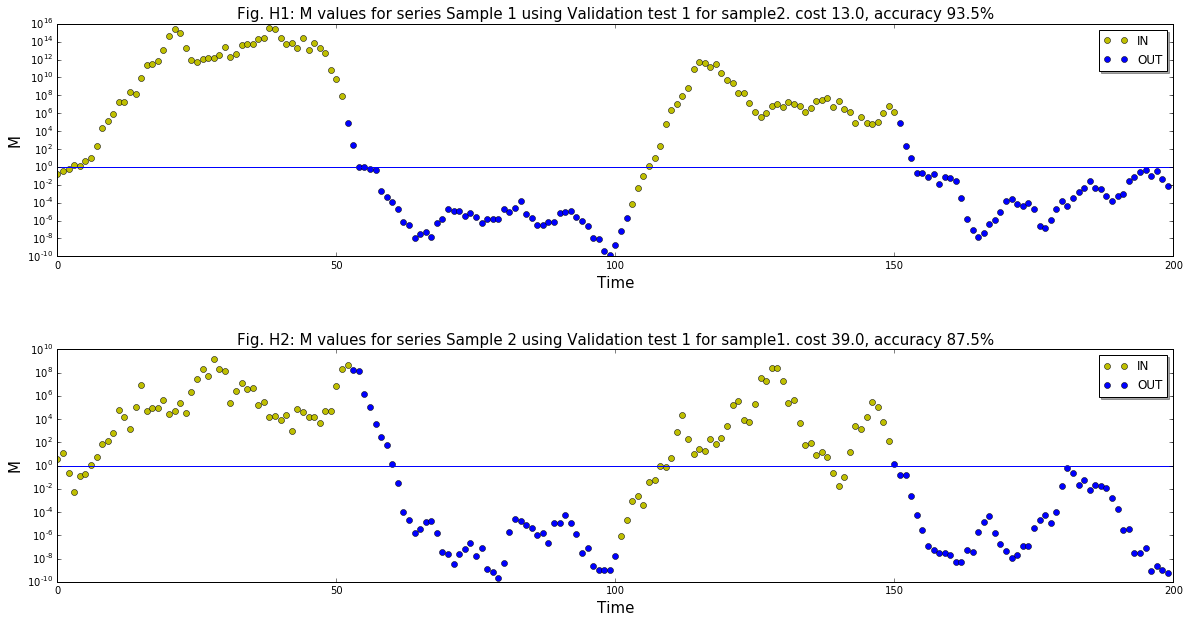

In [15]:
model11 = build_model(df11, df12, 'Validation test 1 for sample1')
model12 = build_model(df12, df11, 'Validation test 2 for sample1')
model21 = build_model(df21, df22, 'Validation test 1 for sample2')
model22 = build_model(df22, df21, 'Validation test 2 for sample2')

chosen1 = model11 if model11['accuracy'] > model12['accuracy'] else model12
chosen2 = model21 if model21['accuracy'] > model22['accuracy'] else model22

fig, ax = plt.subplots(2, 1, figsize=(20, 10))
plt.subplots_adjust(hspace=0.4)
plot_series(sample1, chosen2, ax[0], "Sample 1", "H1")
plot_series(sample2, chosen1, ax[1], "Sample 2", "H2")


We see overfit avoiding code improves sample2 results by 2% while sample1 results remain the same. We also see that for sample1 there are no longer spurious events while for sample2 one spurious event remains but has very short duration. Another observation is that the much increased value of N does not produce comparable delays in event detection. In general this last improvement produces the best model overall.
With these adjustments we improve our accuracy from 90% to 93.5% for sample1 while for sample2 we get a marginal increase from 87% to 87.5%.

#### Handling spurious events

As we can see from the diagrams in the implementation section, our algorithm is not getting rid of all spurious events. They still happen sometimes. This is due to the probabilistic nature of the system and the fact that we have observed the variance in the data is quite high. If we keep the algorithm as is, it will someimes generate spurious events we don't want. I've been thinking about solutions in order to at least mitigate this problem. One first thing I attempted and implemented was a concept I would call Conditional Thresholds. The fundamental idea is to identify a range of values for M around 1 that is the "no one land". In practice, while I am in this range, no event is ever signalled. This causes additional delays in the signalling of real events but is a trade off we must accept in order to avoid spurious events.

The logic is conditional. We have two thresholds for IN and OUT. The IN threshold is higher than 1 while the OUT threshold is lower than 1. When we are IN we use the OUT threshold as our event signalling threshold. On the contrary when we are OUT we use the IN threshold as our event signalling threshold. This should work quite well but the problem is determining the optimal value for the thresholds. Now. this might suggest using an SVM to derive the optimal thresholds but actually a SVM is not of good use in this context since the number of correct observations inside the threshold is always higher than the number of misclassified ones and a SVM would choose values very near to 1 in order not to misclassify the correct observations.
So I first started using the maximum observed values for the observations that belong to spurious events. For example, to determine the IN threshold I can use the maximum observed value for blue (OUT) observations on spurious events where their M is above 1. This eliminates completely any spurious events from our training samples but is quite rough an approach. Actually, given the high data variance we observe, the threshold values computed in this way tend to be arbitrary and may cause too much delay in event detection or may fail to suppress spurious events in other real world samples.

There is also another approach to solve the problem. Instead of defining thresholds one possibility is to delay event signalling until we are quite sure the event actually happened. This is based on the same rationale as the use of joint probabilities and can be seen as a "second order" approach to variance management. Often, people entering a room will stay there for more than a few seconds. Our spurious events actually have a limited duration of a few seconds, in particular after the last improvements. A solution can be to wait signalling until we have detected at least W consecutive values that support the event. One way to determine the value of W may be to count the length of the biggest sequence of misclassified samples about all observed spurious events, excluding the initial observations up to N. This W value is somewhat complementary to N. If N is large we generally need a smaller value, while if N is small we need a bigger value. That's because if N is large the the curve is smoother and vice versa.

I implemented versions of both solutions in my JavaScript code and it seems on actual testing the second one is better at solving the spurious event problem but the jury is still out on which approach works best.

In practice we should not use our training data to determine the thresholds or the W parameter but instead we should use unseen data. We could use the test data that the operator collects to test the model after the collection of the training sample. The operator may signal spurious events detected by the system during the test phase and the system may tune itself using this additional data. This is currently not implemented.

#### Handling the potentially lost OUT event

One thing the algorithm is missing to handle is the possibility of losing the (last) OUT event. Since we use windows to detect an event, it takes a number of observations to detect an OUT event in order to signal it, and this becomes worse if we add the delayed decision approach described in the previous section. If the beacon is carried out of the room quickly then the signal may disappear before we actually have enough observations to decide the OUT event has happened. The system will simply suspend waiting for a new event to be detected. This event may happen hours later and will continue the existing series, when it should instead start a new series of observations. Clearly we need a way to always complete a series eventually.

In order to solve this problem we will make use of the discarded delay feature. The idea is to measure the maximum delay experienced for IN labelled observations and use a timer to periodically check if the elapsed time since the last received signal for a beacon is greater than, say, twice this value. For example, for sample1 the maximum delay for IN is 2016ms. We can be quite sure that if we have not been receiving a new signal in the last 4 seconds, then the beacon is probably gone. In this case we signal the OUT event and clear out the beacon information in order to start the next series in a clean state. This has been implemented in the JavaScript version of the system but I don't see much value in doing this in the python version since this version lacks the runtime that processes the live stream of signals from the beacons. The implementation is quite trivial anyway.

## IV. Results

### Model Evaluation and Validation

The model in this project is in reality an instance of a family of models. As I said in the problem statement we evaluate a model for each room in the building we need to monitor. The samples I used to derive and illustrate the algorithm come from a single test room I used during development. Since then the algorithm has been tested on many different rooms in a large building in Rome and it seems to work quite well for differing room sizes and furniture.
As we can see from our samples, different samples can produce significantly different models. This is to be expected since we use a single sample to learn the model parameters. 
Most of the times the models we collect in the real world are not so different and perform similarly but we have seen that sometimes the collected samples produce models that are not robust enough to be used in practice. In these cases the operator collects another sample until testing shows that the learned model is good enough. We are currently investigating the factors that allow us to get a "good" sample on the field at the first attempt. 

Increasing the sample size so that we can increase the possibile cross validated combinations is probably a good approach to follow. But it takes more operator time, so it should be done only when necessary. Actually, when the model turns out not to be good enough, further data collection allows us to improve it using these techniques.

### Justification

In the Benchmark section we already saw that our benchmark model, on these datasets, has an expected accuracy around 50%. Our new model has shown, on the same data, accuracy results in the range 87.5-93.5% so we can conclude that our ML based algorithm is significantly better than the benchmark solution we started with.
The final solution with the improved cost model, the cross validation approach and the spurious event removal logic seems adequate to consider the problem solved for practical purposes. This does not mean there can't be a better solution using some alternative algorithm or ML technique. I discuss about potential alternatives in the Conclusion.

## V. Conclusion

### Free-Form Visualization

In the end what matters is event detection. This is how our best solution works in our two samples:

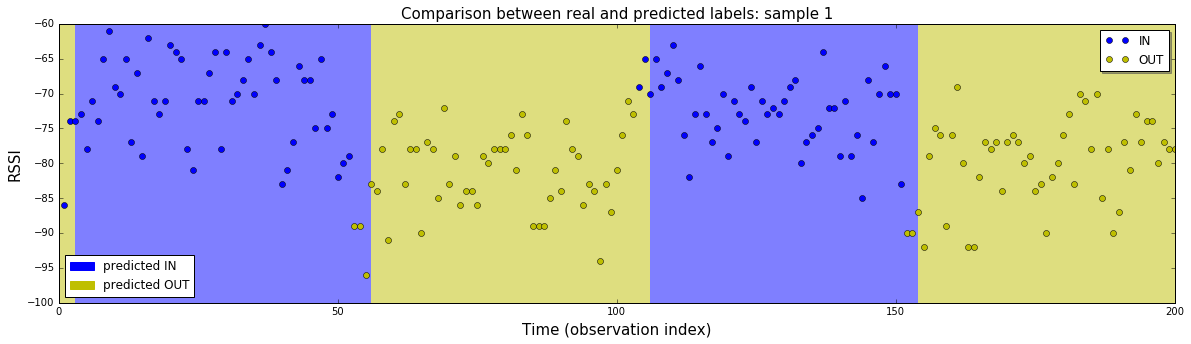

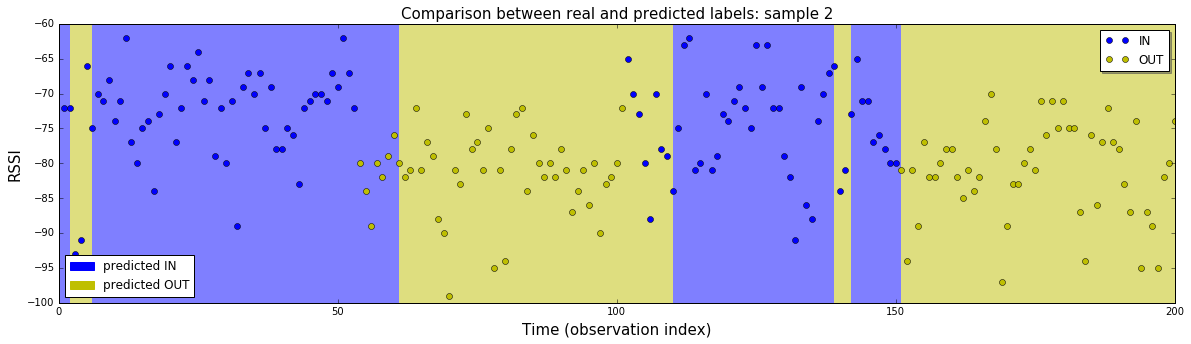

In [16]:
import matplotlib.patches as mpatches

def split_shade(sample, ax):
    splits = split(sample)
    start = 0
    for s in splits:
        c = 'b' if s[0]['pos'] == 0.0 else 'y'
        ax.axvspan(start, start + len(s), color=c, alpha=0.5, lw=0)
        start = start + len(s)

def banded_plot(sample, sampleId, model):
    fig, ax = plt.subplots(1, 1, figsize=(20, 5))
    ax.set_xlabel("Time", fontsize=15)
    ax.set_ylabel("RSSI", fontsize=15)
    ax.set_title("Comparison between real and predicted labels: sample " + sampleId, fontsize=15)
    blue_patch = mpatches.Patch(color='b', label='predicted IN')
    yellow_patch = mpatches.Patch(color='y', label='predicted OUT')
    legend = plt.legend(handles=[blue_patch, yellow_patch], loc=3)
    plotSegmentedSeries(sample, ax, sampleId, False)
    (cost, mis, values, labels) = evaluate_series(sample, model)
    ser = pd.DataFrame({'rssi': [-59]*len(values), 'pos': [0.0 if v >= 1.0 else 1.0 for v in values]})
    split_shade(ser, ax)
    plt.gca().add_artist(legend)

banded_plot(sample1, "1", chosen2)
banded_plot(sample2, "2", chosen1)

This shows the original data along with the classification defined by the shaded regions. We can see that the system is quite good at classifying the data into IN and OUT regions. The first observations up to the window size in the sample are generally misclassified and in the software we wait to have at least N recorded observations before taking a first decision, so we can ignore the misclassifications at the start of the samples. There is a spurious OUT event in the second sample but it only lasts three seconds (I've not applied the spurious events corrections here). In practice it would be possibile to cope with it by other means. For example the software that uses this results may know that this kind of errors may happen and may be programmed to take its own decisions with this knowledge.
We can also se that the average event detection delay for the first sample is under 3 seconds while for the second example it nears 5 seconds. These values are acceptable for the problem we needed to solve.

### Reflection

This project has been a bit different from other projects I have faced during MLND, not only because I had to do it from scratch on a real world problem, but because it is different from the typical ML problems I have seen during my learning experience. 

First of all we are confronted with a time series. The data being a time series introduces some difficulties, in particular for cross validation.

The second thing is we have only one feature. In general in ML problems we have datasets with many features and the problem is to select the most relevant for the task at hand in order not to introduce variance and make the model capable of better generalization. In this case I only had one since it was evident from the start that the delay, a feature I imagined useful a priori, was really not relevant to predict our target feature. Having only one useful feature available is a significant limitation.

Another problem was that I had a limited amount of data. I could collect any amount of data for this project but I wanted to stay within the limitations of the real world this system has to run on. In practice we have small dirty samples, and the technology we use produces data that is quite messy. I had to deal with this reality.

Another aspect of this project has been the need to be creative and think about a suitable model that wasn't available out of the box. If I had the time to try something more complex I would definitely try some sort of Neural Network. I'm going to describe more about this possibility in the next section. The idea of using a probabilistic model was in my opinion the one best fitting the problem. I used the time series characteristic in the data to my advantage introducing the concept of a joint probability over a window of observations. So the need to estimate the N hyperparameter arose and I devised an approach to perform cross validation using the time series, taking advantage of the sampling procedure I devised for operators.

The domain problem clearly stresses the importance of avoiding spurious events detection even at the expense of grater delays in event detection. With this requirement in mind I studied some strategies to minimize the probability of spurious events, by implementing a better cost model and by introducing algorithmic corrections that reduce the error rate in a significant manner (Conditional Thresholds and forced delays).

In the end I found this project very useful for me since I have many years of programming experience in disparate languages and platforms and it was beautiful to see how ML and classical programming approaches can be used together to solve a tough real world problem. ML alone or classical programming alone could not solve this problem. It was their combination that worked. This is going to be the norm in real world product development for ML (and AI) based products. I am excited to be in this position in this moment in history in which the Cloud, IoT, AI and ML are going to be, along with bioengineering and nanotech, disruptive technologies that will have a profound impact in the future of humanity.

Going back to earth, I find my final model and solution are quite good and can be used in a real world setting. I think there is still room for improvement but I am quite satisfied with the result given the problem constraints.

### Improvement

There are some aspects of the implemented system that may be improved:
- Quality of data collection and data collection strategies. We have seen that samples are sensitive to the way operators collect data. We need to study the best procedure and train field personnel in order to get good samples that produce good models in the least amount of time;
- We may consider increasing the collected sample size in the future to improve the models. For example, with 300 observations we can collect three subsamples and test 6 combinations for cross validation. We could also reduce the relative size of the subsamples to collect more of them, say, reducing the percentage to 20%, but we need to see if this has significant impact on the precision of estimation of gaussian parameters and the N hyperparameter;
- we could use weighted probabilities, where we conserve the window concept but weight the probabilities differently to compute the joint in order to give more weight to recent observations. This may reduce latencies (but may increase spurios events). The problem with this is our metric M. If we use weighted probabilities with this metric, the weights cancel out. In order to use weights we need to rethink our metric in a way that permits their use. In general there may exist a better metric that I have not thought of.
- the reviewer suggested to explore a Momentum based solution for the spurious events problem. While I know about momentum in the context of Neural Networks, where it is used to avoid being stuck in local minima, I presume here it would be used to smooth the M function in the hope it will be able to cancel out the low duration spurious events sequences. A solution may be to use a (hyper)hyperparameter $\alpha$ used to compute a weighted average of the last M values where $\alpha$ decreases exponentially. I think this was the suggestion, and actually may be a promising future work direction, but can introduce further delays like the other techniques I developed albeit with minor strength given the exponential decay in the weights:

$$M' = M_{N} + \alpha M_{N-1} + \alpha^{2}M_{N-2}...$$


As a final consideration, we may try different approaches to the problem if we had more time and resources:
- may we use a Neural Network? There are some types of NN that may be used for this task. In particular Recurrent Neural Networks (https://en.wikipedia.org/wiki/Recurrent_neural_network), like LSTM (Long Short Term Memory, https://en.wikipedia.org/wiki/Long_short-term_memory) networks have been successfully employed for time series analysis, in particular for financial applications. These are NN that feed their results back into the network in order to be able to deal with data that has time based correlation (like time series, text and spoken language). They may be used in a supervised learning setting and adapted for binary classification tasks like ours. There are a few aspects that made me avoid this route as the first choice: the small size of the data samples; the fact in the field we collect only one sample; the consequent high risk of overfitting and the relative greater complexity of their usage with respect to my probabilistic solution;
- there may be a better probabilistic model that I could use. In my setting I am not completely taking advantage of the autocorrelation present in the time series. I already affirmed that the model should work even in the independent observations assumption but if I had a way to teach the model to recognize a correlation when the beacon moves then it may be possibile to greatly improve the timeliness of event detection and improve our ability to distinguish between real and spurious events. This may be an interesting development. The idea is to detect a linear trend in the RSSI. When the beacon is stationary there is no trend and we observe noise with given mean and standard deviation. Once the beacon moves, a trend should be detectable. A problem is the trend can be observed even when the user simply moves inside the room without exiting from it. Anyway a trend may suggest an incoming event and may add useful information to improve the model quality;
- there may be a model that is not based on a single room but is more general. In this model we could introduce more features, like room sizes and furniture density and so on. We could use data captured in many different scenarios to create a more general model that works in a general setting. This may eliminate the need to train the system room by room every time, but I guess building such a model and make it work as well as the one I already built would be a much greater challenge. But it may be worth exploring since we can say that a lot of the variance we see in the data is intrinsically generated by the beacons, which are the same on every room. Here I suspect some form of neural network or ensemble may be quite effective.